Welcome to an exercise where we will be replicating the discovery of the Z boson. We'll be making it easier for ourselves by using data from the Large Electron-Positron collider which was used to more precisely research properties of the Z bosons and can produce Z boson a lot better than the Super Proton Synchrotron which originally discovered it. The main problem with discovering the Z boson is the actual detection. Since Z bosons lifetime is very short it will decay into other particles, before we can detect it. One of the possible products of the decay can be 2 muons, which we can detect and will focus on. Here we will only use data of these double muons that come from Z particles. From the muons we can work backwards and calculate the mass of the particle that they decayed from. If we discover a lot of mass values that match the theoretical predictions of a Z boson, we have found it.

Start with the necessary imports and reading the datasets of github. The datasets can be combined using the `concat()` function:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

dataset91 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short91_f1_000.csv.gz',index_col=False)
dataset92 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short92_e2_000.csv.gz',index_col=False)
dataset93 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short93_d2_000.csv.gz',index_col=False)
dataset94 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short94_c2_000.csv.gz',index_col=False)
dataset = pd.concat([dataset91, dataset92, dataset93, dataset94])

Z bosons decay is a relativistic process, so we can't solve its mass just by adding up the masses of the products, since some of the mass can turn into energy. We need to define a new definition of mass, which we can get from relativistic theory: Invariant mass. In particle physics it's commonly defined as 

$$
M c^2 = \dfrac{E^2}{c^2} - ||p||^2
$$


Because both energy and momentum are conserved, the invariant mass is also conserved and therefore we can calculate the invariant mass of the Z boson by calculating the invariant mass of the products. To calculate the combined invariant masses we can use the formula:

$$
Mc^2 = \sqrt{(E_1 + E_2)^2 - c^2 (\vec{p}_1 + \vec{p}_2)^2 }
$$

To simplify the calculations we can use natural units where $c=1$. If you just do this the program will give you a warning about negative values under the square root. Due to measurement error some values will infact be negative. Since they are caused by measurement error they are all quite small and will just be removed for now. 

If you try to do that, you'll first notice an error caused by mistakes in the data. After some tests you'll notice that there are some values of PZ1 with the value `**********`. First we remove those from the dataset and then change the datatype of the values to float64 since the values were saved as strings.

In [2]:
dataset = dataset[dataset.PZ1 != '**********'] #removes datapoints where PZ1 is **********
dataset = dataset.astype({'PZ1': 'float64'}) #convert the strings to floats for the upcoming calculations

#removing negative values:
dataset = dataset[(dataset.E1 + dataset.E2)**2 - (dataset.PX1 + dataset.PX2)**2 - (dataset.PZ1 + dataset.PZ2)**2 - (dataset.PY1 + dataset.PY2)**2 > 0]

#calculating invariant mass:
dataset["M"] = np.sqrt((dataset.E1 + dataset.E2)**2 - (dataset.PX1 + dataset.PX2)**2 - (dataset.PZ1 + dataset.PZ2)**2 - (dataset.PY1 + dataset.PY2)**2)
dataset.head()

,NRUN,IEVT,ECM,E1,P1,PT1,PX1,PY1,PZ1,Q1,...,PT2,PX2,PY2,PZ2,Q2,PHI2,THETA2,MISSPT,MISSPHI,M
0,20631,746,91.250,41.847,41.847,41.725,-40.788,8.793,3.192,-1.0,...,46.693,33.017,-7.097,-2.666,1.0,-0.212,1.650,7.954,-0.215,75.302266
1,20694,1956,91.286,110.783,110.783,42.253,35.688,-22.621,-102.408,1.0,...,24.881,17.593,-10.661,-59.187,-1.0,-0.545,2.807,62.821,2.583,4.829143
2,20704,767,91.280,28.322,28.322,28.305,7.921,-27.174,0.977,-1.0,...,9.863,-6.974,21.395,-0.104,1.0,1.886,1.575,5.857,1.733,50.478954
3,20723,1571,91.282,42.509,42.508,42.505,32.779,27.059,0.552,-1.0,...,44.330,-31.346,-25.960,-0.312,1.0,-2.450,1.578,1.806,-2.487,83.191055
4,21112,148,91.282,39.894,39.894,39.845,-7.051,-39.216,-1.980,1.0,...,8.602,6.083,35.568,-2.199,-1.0,1.401,1.632,3.774,1.311,75.837228


Now let's plot the histogram of the invariant mass values. We should see it spike where around the Z bosons invariant mass:

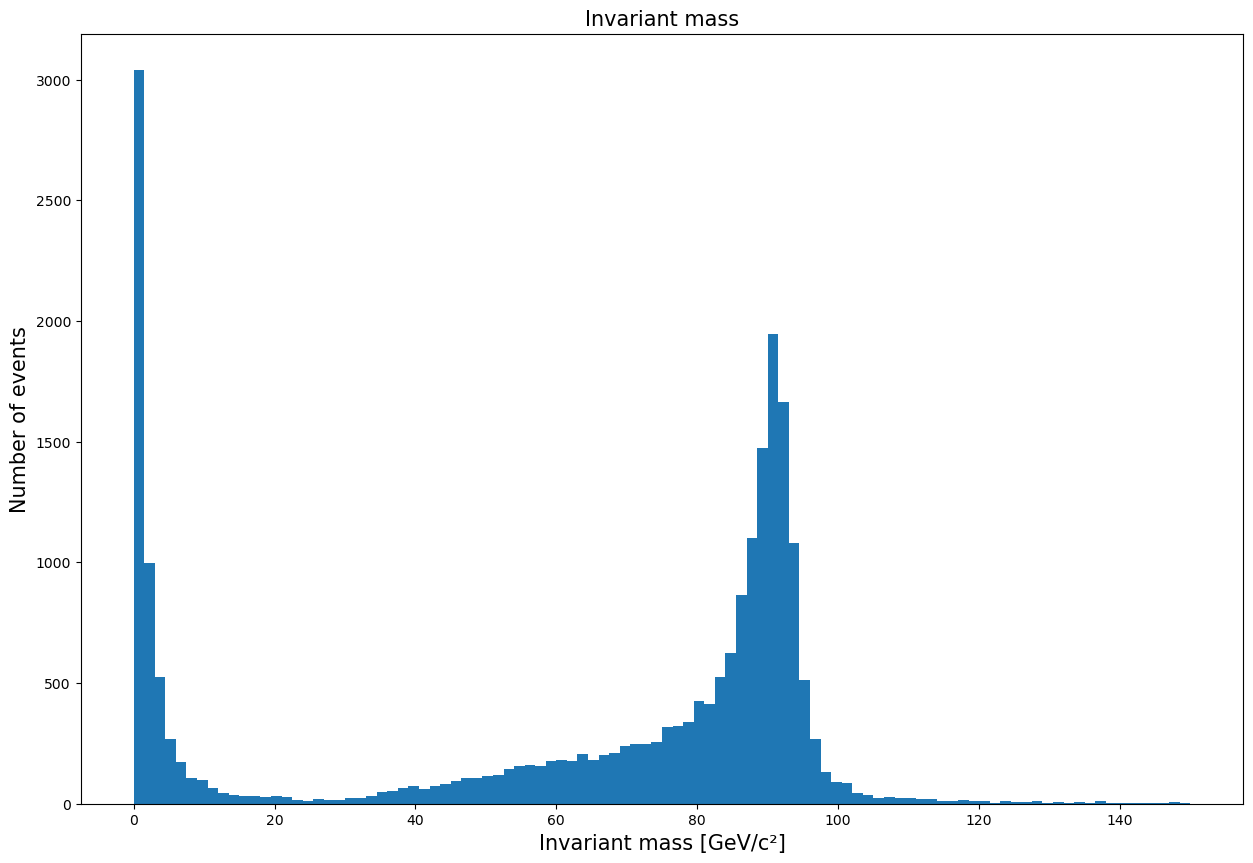

In [3]:
lowerlimit = 0
upperlimit = 150
bins = 100

fig = plt.figure(figsize=(15, 10))
plt.hist(dataset.M, bins=bins, range=(lowerlimit, upperlimit))

plt.xlabel('Invariant mass [GeV/c²]', fontsize=15)
plt.ylabel('Number of events', fontsize=15)
plt.title('Invariant mass', fontsize=15) 

plt.show()

Now that we have the histogram we can start analysing it. There is a peak (often called a resonance) at around 90 GeV. This peak signifies a particle. We can actually get more from this histogram. This is done by plotting what is called a Breit-Wigner function on the histogram. Breit-Wigner distribution is of the following form:

$$
f(E) = \dfrac{k}{(E^2 - M^2)^2 + M^2 \Gamma^2} 
$$

where $k = \dfrac{2\sqrt{2}M \Gamma \gamma}{\pi\sqrt{M^2 + \gamma}}$ with $\gamma = \sqrt{M^2(M^2 + \Gamma^2)}$ which are in natural units $\hbar = c = 1$. 


Let's start with the simple parts of the fitting. First we limit ourselves to the area around where we know the particle is by setting limits to the mass values and remove the rest from the dataset. Then we set the initial guesses. In this fit there are 5 variables. We can guess that the max values is the peak we saw in the histogram. The rest we can guess and if the plot isn't good try again.

In [4]:
#limit to where Z-boson should be:
lowerlimit = 70
upperlimit = 100
bins = 50

#Create a histogram only around the peak
histogram = plt.hist(dataset.M, bins=bins, range=(lowerlimit,upperlimit), density = True) 
plt.close() #stop from showing the plot

#Initial guesses:
initials = [5, 90, 4, 2, 4]

Next step is to create the fit. First we define a function that matches the form of the Breit-Wigner function given earlier. We can actually get the (x,y) coordinates of the histogram easily since we saved it in the previous cell. Then we fit this function into those values using `curve_fit()` from the `scipy.optimize` library. Let's also save the best values and covariance that the fitting gives us. 

In [5]:
from scipy.optimize import curve_fit


def breitwigner(E, gamma, M, a, b, A):
    return a*E+b+A*( (2*np.sqrt(2)*M*gamma*np.sqrt(M**2*(M**2+gamma**2)))/(np.pi*np.sqrt(M**2+np.sqrt(M**2*(M**2+gamma**2)))) )/((E**2-M**2)**2+M**2*gamma**2)

#Histogram as an object consists of 2 lists: List of the heights of the bars and the edges of the bins
#Using normal list operations we can use the histogram to get x and y coordinates:
y = histogram[0] #gives the height of each bar in a list
x = 0.5*(histogram[1][0:-1] + histogram[1][1:]) #list of midpoints of a bins

#Fits the defined Breit-Wigner function to the (x,y) points gotten from the histogram
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y)) #sigma is the magnitude of the uncertainty in y-data

Lastly we plot both this fitted function and the histogram into the same picture. We can also print the best values and their limits of error, which can be easily calculated from the covariance. 

The values and the uncertainties from the optimization:

The value of the decay width = 7.331249406371135 +- 0.4164503544202277
The value of the maximum of the distribution = 90.62289341074475 +- 0.10224714644762699
a = -0.0007510517729099229 +- 6.683925696144588e-05
b = 0.0645053820314331 +- 0.004974890432405653
A = 1.1499927881248468 +- 0.06141079247278257


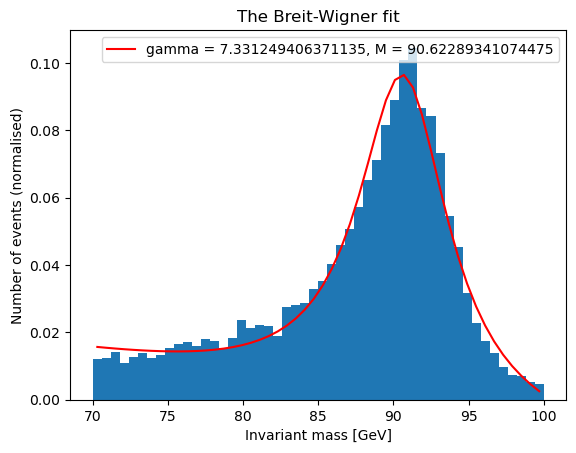

In [6]:
#Covariance is is determined using the sigma given. The diagonal elements are the variances.
error = np.sqrt(np.diag(covariance))
    
#Parameters and their errors from optimization:
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

#plot both graphs:
plt.hist(dataset.M, bins=bins, range=(lowerlimit,upperlimit), density = True)
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

A large missing potential is a indicator that the measurement may be inaccurate. Let's remove ones with a large missing potential and see if it makes the results more accurate:

The values and the uncertainties from the optimization:

The value of the decay width = 6.287990093175185 +- 0.22398052908293392
The value of the maximum of the distribution = 90.81040350230872 +- 0.0632106915502224
a = -0.00048319996178003937 +- 3.9378780835776925e-05
b = 0.03413027060543081 +- 0.0028409636026892025
A = 1.3923794178625235 +- 0.04081338475829412


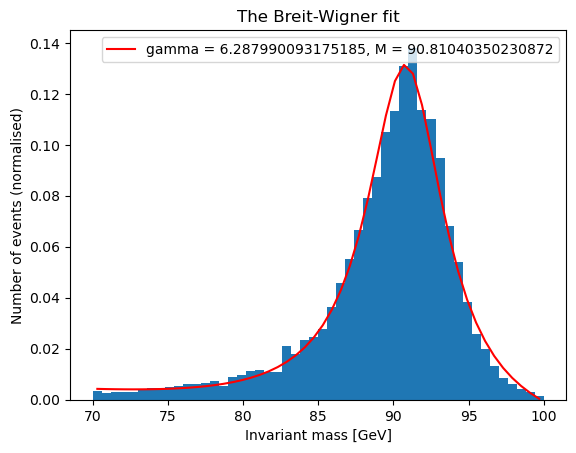

In [7]:
missing_pot_limit = 5
limited_missing_pot = dataset[dataset.MISSPT < missing_pot_limit]
histogram = plt.hist(limited_missing_pot.M, bins=bins, range=(lowerlimit,upperlimit), density = True)


def breitwigner(E, gamma, M, a, b, A):
    return a*E+b+A*( (2*np.sqrt(2)*M*gamma*np.sqrt(M**2*(M**2+gamma**2)))/(np.pi*np.sqrt(M**2+np.sqrt(M**2*(M**2+gamma**2)))) )/((E**2-M**2)**2+M**2*gamma**2)

#Initial guesses:
initials = [5, 90, 4, 2, 4]

#use the histogram to make a function:
y = histogram[0]
x = 0.5*(histogram[1][0:-1] + histogram[1][1:])
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y))
error = np.sqrt(np.diag(covariance))
    
#Values from optimization:
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))


#plot graph:
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

It does seem to actually be more accurate, although it didn't make a big difference. Now let's compare to modern CMS data. We'll do the same steps as for the LEP data. 

The values and the uncertainties from the optimization:

The value of the decay width = 4.177200839163412 +- 0.15501257717258565
The value of the maximum of the distribution = 90.85095018949904 +- 0.04936129215048532
a = -0.00027224038908471164 +- 4.453412936672804e-05
b = 0.02361297095940811 +- 0.003389383968053174
A = 1.0759602426227084 +- 0.030646946842425294


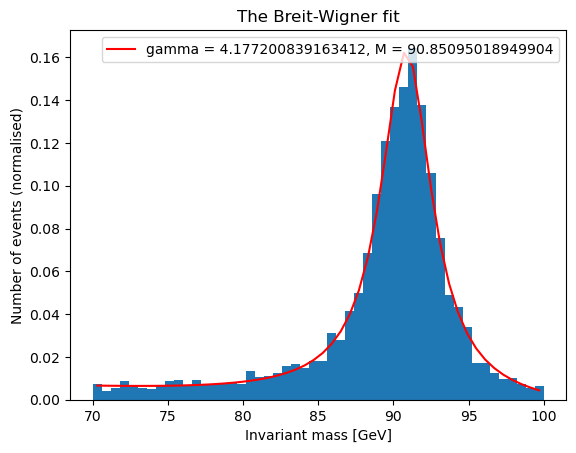

In [8]:
dataset_CMS = pd.read_csv('https://raw.githubusercontent.com/cms-opendata-education/cms-jupyter-materials-finnish/master/Data/Dimuon_DoubleMu.csv')
                        
lowerlimit = 70
upperlimit = 100
bins = 50

#Change the dataset to be only that area
limitedmasses_CMS = dataset_CMS[(dataset_CMS.M > lowerlimit) & (dataset_CMS.M < upperlimit)]
histogram = plt.hist(limitedmasses_CMS.M, bins=bins, range=(lowerlimit,upperlimit), density = True) 
plt.close() #stop from showing the plot

#Initial guesses:
initials = [5, 90, 4, 2, 4]
                      

#Histogram as an object consists of 2 lists: List of the heights of the bars and the edges of the bins
#Using normal list operations we can use the histogram to get x and y coordinates:
y = histogram[0] #gives the height of each bar in a list
x = 0.5*(histogram[1][0:-1] + histogram[1][1:]) #list of midpoints of a bins

#Fits the defined Breit-Wigner function to the (x,y) points gotten from the histogram
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y)) #sigma is the magnitude of the uncertainty in y-data
#Covariance is is determined using the sigma given. The diagonal elements are the variances.
error = np.sqrt(np.diag(covariance))
    
#Parameters and their errors from optimization:
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

#plot both graphs:
plt.hist(limitedmasses_CMS.M, bins=bins, range=(lowerlimit,upperlimit), density = True)
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

This is barely more accurate than than the LEP data using invariant masses, but since for LEP we can also use the line width fit method, we actually get the invariant mass of a Z boson more accurately from LEP data than from the LHC. We can actually make the CMS data more accurate using pseudorapidities (insert explanation of how and why here!).

In [29]:
dataset_CMS.head()
small_etas = dataset_CMS[(np.absolute(dataset_CMS.eta1) < 0.6) & (np.absolute(dataset_CMS.eta2) < 0.6)]

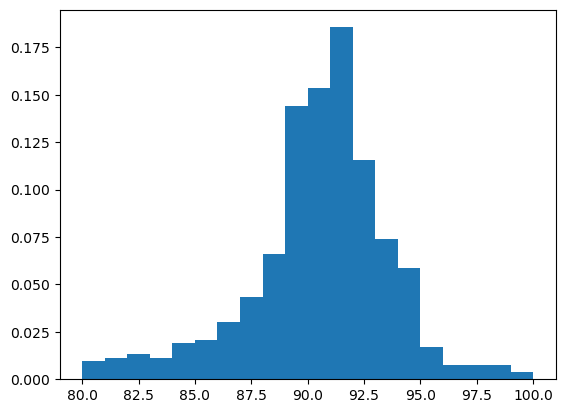

In [30]:
bins=20
lowerlimit = 80
upperlimit = 100
histogram = plt.hist(small_etas.M, bins=bins, range=(lowerlimit,upperlimit), density = True) 

initials = [5, 90, 4, 2, 4]
                      


The values and the uncertainties from the optimization:

The value of the decay width = 3.871397040043242 +- 0.3655775122841281
The value of the maximum of the distribution = 91.02585355434009 +- 0.11787645249229474
a = -0.0004891485951908682 +- 0.00017434928537303385
b = 0.041753095864842875 +- 0.01609958500490004
A = 1.155746396133551 +- 0.08373311850570979


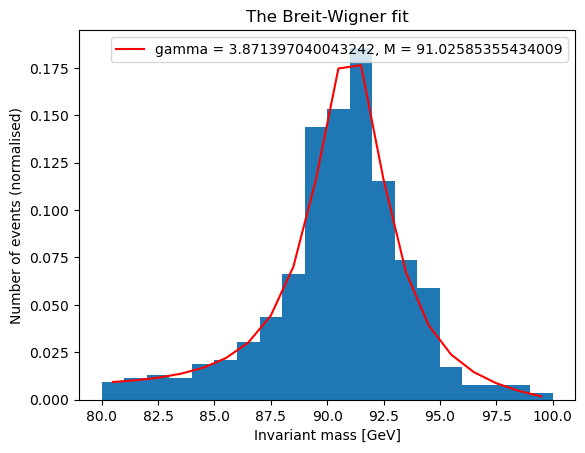

In [31]:
y = histogram[0] 
x = 0.5*(histogram[1][0:-1] + histogram[1][1:]) 

best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y)) 
error = np.sqrt(np.diag(covariance))
    
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

plt.hist(small_etas.M, bins=bins, range=(lowerlimit,upperlimit), density = True)
plt.plot(x, breitwigner(x, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()